<a href="https://colab.research.google.com/github/aasyngier/machine-learning/blob/main/ml_homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Analyzing and Plotting Bias in Penalized Regression**

-------------------------------

In this assignment, you will explore how **Ridge** and **Lasso** regression introduce **bias** into a model to reduce **variance**, and how the choice of the regularization parameter $\lambda$ affects this trade-off. The goal is to visualize and analyze the **bias-variance trade-off** and understand the conditions under which penalization helps or hinders model performance.

## **The Question**

**How does varying the regularization parameter $\lambda$ in Ridge and Lasso regression impact the trade-off between bias and variance?**

- Generate a synthetic dataset based on a **known** linear relationship:
  
  $$
  y = \beta_0 + \beta_1 x + \ldots + \epsilon
  $$

  where $$\epsilon \sim \mathcal{N}(0, \sigma^2),$$

  use a **high-dimensional** setting (e.g., 50 predictors) with only a few non-zero true coefficients to emphasize the effects of regularization. I stress, the $\beta_i$ coefficients should be known for this experiment and they should be mostly 0, with only a few non-zero parameters.

- Investigate how increasing $\lambda$ influences the model’s **bias**, **variance**, and **Mean Squared Error (MSE)**.
- Plot **Bias²**, **Variance**, and **MSE** on a single graph for both Ridge and Lasso models.
- Explain MSE decomposition into bias and variance. Read more on the MSE decomposition if you need to.

**Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.**




**Expected Outcome:**
 - As $\lambda$ increases:
   - **Bias** increases (the model becomes too simple).
   - **Variance** decreases (the model becomes more stable).
   - **MSE** forms a **U-shape**, revealing the optimal trade-off.

- Analyze how **Ridge** and **Lasso** differ in terms of their bias-variance trade-offs.
- Discuss situations where one method may outperform the other, considering factors like **feature sparsity** and **multicollinearity**.


## **Colab Notebook Requirements**
- Your **Colab notebook** should:
  - Simulate the synthetic dataset and apply Ridge and Lasso regression.
  - Plot **Bias²**, **Variance**, and **MSE** against $\lambda$ for both models.
  - Include a section answering the questions.
  - Be well-documented with comments and explanations for each step.




##**1. Imports**

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, lasso_path
from sklearn.preprocessing import StandardScaler

##**2. Simulation Parameters**

In [13]:
np.random.seed(42) # for reproducibility

n_features = 50         # Total number of predictors
n_nonzero = 5           # Number of predictors with nonzero coefficients
n_train = 100           # Number of training samples per experiment
n_test = 1000           # Number of test samples (fixed across experiments)
n_experiments = 100     # Number of experiments (training set resamples)
noise_std = 1.0         # Standard deviation of the noise

beta = np.zeros(n_features)
beta[:n_nonzero] = np.random.uniform(1, 2, size=n_nonzero)

alphas = np.logspace(-3, 3, 100)

##**3. Generate a fixed test set**

In [14]:
X_test = np.random.randn(n_test, n_features)

y_test_true = X_test.dot(beta) # Compute the true response (without noise) for bias calculations

##**4. Simulation over Multiple Training Sets**

In [38]:
ridge_preds_list = []
lasso_preds_list = []

for exp in range(n_experiments):
    X_train = np.random.randn(n_train, n_features)
    noise = np.random.randn(n_train) * noise_std
    y_train = X_train.dot(beta) + noise

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ridge_coef has shape (n_features, n_alphas)
    ridge_coef = np.column_stack([
        Ridge(alpha=a).fit(X_train_scaled, y_train).coef_ for a in alphas
    ])

    # predictions on the test set for each alpha: shape becomes (n_test, n_alphas)
    ridge_preds = X_test_scaled.dot(ridge_coef)
    ridge_preds_list.append(ridge_preds)

    # lasso_path returns coefficients of shape (n_features, n_alphas)
    lasso_alphas, lasso_coefs, _ = lasso_path(X_train_scaled, y_train, alphas=alphas, max_iter=10000)
    lasso_alphas = lasso_alphas[::-1] # reverse the array of alphas
    lasso_coefs = lasso_coefs[:, ::-1]
    lasso_preds = X_test_scaled @ lasso_coefs
    lasso_preds_list.append(lasso_preds)

# stack predictions over experiments: shape (n_experiments, n_test, n_alphas)
ridge_preds_all = np.stack(ridge_preds_list, axis=0)
lasso_preds_all = np.stack(lasso_preds_list, axis=0)

##**5. Bias-Variance-MSE Decomposition**

For each α, we compute:
 - **Bias²:** The squared difference between the average prediction (over experiments) and the true response, averaged over test samples
 - **Variance:** The variability (variance over experiments) of the predictions at each test point, averaged over test samples.
 - **MSE:** The mean squared error of the predictions compared to the true response.

The decomposition follows:

\begin{aligned}
\text{MSE}(x) &= \mathbb{E}\left[\left(y - \hat{f}(x)\right)^2\right] \\
              &= \mathbb{E}\left[\left(f(x) + \epsilon - \hat{f}(x)\right)^2\right] \\
              &= \underbrace{\left(\mathbb{E}[\hat{f}(x)] - f(x)\right)^2}_{\text{Bias}^2}
              + \underbrace{\mathbb{E}\left[\left(\hat{f}(x) - \mathbb{E}[\hat{f}(x)]\right)^2\right]}_{\text{Variance}}
              + \underbrace{\sigma^2_{\text{noise}}}_{\text{Irreducible Noise}}
\end{aligned}


In [39]:
def compute_metrics(preds_all, y_true):

    # Compute the mean prediction over experiments: shape (n_test, n_alphas)
    mean_pred = np.mean(preds_all, axis=0)

    # Bias²: average over test samples of (mean prediction - true value)², for each alpha
    bias2 = np.mean((mean_pred - y_true[:, None])**2, axis=0)

    # Variance: compute variance over experiments for each test sample and each alpha, then average over test samples
    variance = np.mean(np.var(preds_all, axis=0), axis=0)

    # MSE: average over experiments and test samples of (prediction - true value)²
    mse = np.mean((preds_all - y_true[None, :, None])**2, axis=(0,1))

    return bias2, variance, mse

ridge_bias2, ridge_variance, ridge_mse = compute_metrics(ridge_preds_all, y_test_true)
lasso_bias2, lasso_variance, lasso_mse = compute_metrics(lasso_preds_all, y_test_true)

##**6. Plot Bias^2, Variance and MSE for Lasso**

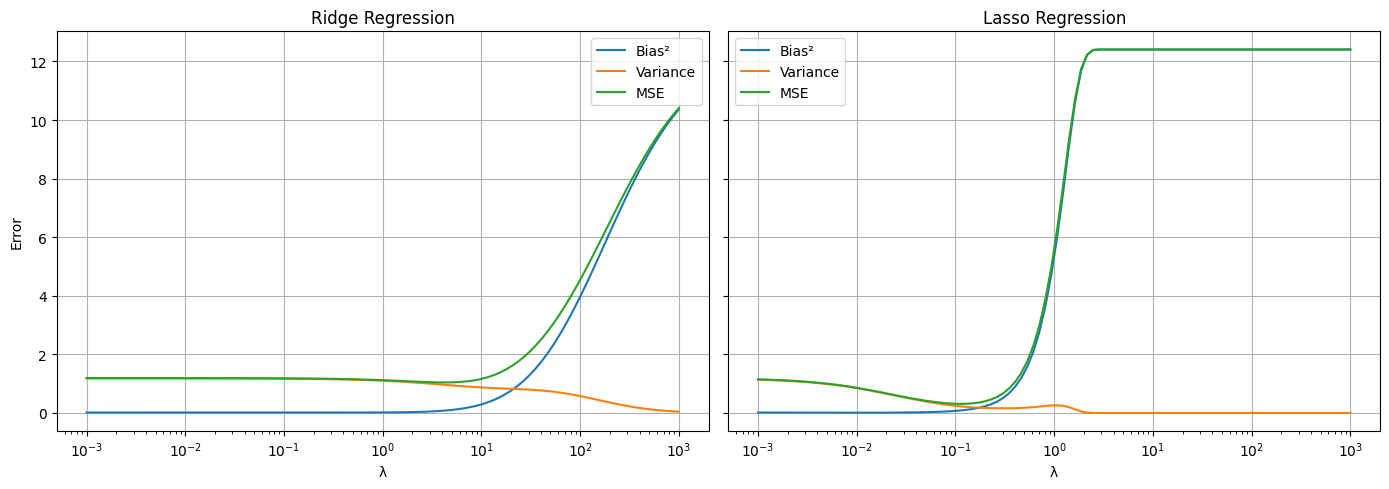

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot for Ridge Regression
ax[0].plot(alphas, ridge_bias2, label='Bias²')
ax[0].plot(alphas, ridge_variance, label='Variance')
ax[0].plot(alphas, ridge_mse, label='MSE')
ax[0].set_xscale('log')
ax[0].set_xlabel('λ')
ax[0].set_ylabel('Error')
ax[0].set_title('Ridge Regression')
ax[0].legend()
ax[0].grid(True)

# Plot for Lasso Regression
ax[1].plot(alphas, lasso_bias2, label='Bias²')
ax[1].plot(alphas, lasso_variance, label='Variance')
ax[1].plot(alphas, lasso_mse, label='MSE')
ax[1].set_xscale('log')
ax[1].set_xlabel('λ')
ax[1].set_title('Lasso Regression')
ax[1].legend()
ax[1].grid(True)
plt.tight_layout()
plt.show()

##**7. Answers to questions**

1. How does varying λ impact the bias-variance trade-off?
As λ increases, both Ridge and Lasso models enforce stronger regularization:
- **Bias increases:** The model’s coefficients are shrunk more aggressively, leading to a simpler (underfit) model.
- **Variance decreases:** With stronger regularization, the predictions become more stable across different training sets.
- **MSE exhibits a U-shape:** At very low λ the low bias is overwhelmed by high variance, while at very high λ the high bias dominates.


2. Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.

  Yes. Regularization introduces a bias-variance trade-off: with very low λ the model overfits (low bias, high variance), and with very high λ it underfits (high bias, low variance). There exists an intermediate λ where the reduction in variance outweighs the increase in bias, minimizing the overall MSE.

3. Comparison between Ridge and Lasso:
- **Ridge Regression:** Tends to shrink coefficients continuously and works well in the presence of multicollinearity, though it rarely sets coefficients exactly to zero.
- **Lasso Regression:** Can set coefficients exactly to zero, promoting sparsity. This is useful when only a few features are important, although it might result in more bias when the key effects are spread out over many features.